# PyTorch Neural Network training (overfitting example)
In this notebook, we'll show how to train a shallow ResNet network on keypoints estimation task with synthetic data. To make the notebook fast to run, we'll use a small dataset of 100 images and overfit the network to this dataset.

## Imports

In [101]:
import os
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import models
import matplotlib.pyplot as plt
from torchsummary import summary
import cv2
from imgaug import augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
from mpl_toolkits.axes_grid1 import ImageGrid

import datagen
from dghelpers import imshow

## Constants definition
The train and test data is located in the main directory. We save a checkpoint of the network locally. The dataset is splitted into 90 train images and 10 test images

In [102]:
DATASET_PATH= '../Training Set'
MODEL_PATH = "model.pth"
IMG_SIZE = 128
BATCH_SIZE = 45 # Ideally should be a power of 2 for efficiency
TRAIN_TEST_RATIO = 0.9
EPOCHS = 100
NUMBER_OF_KEYPOINTS = 68

## Network definition
We use a ResNet-18 network and replace the last fully connected layer with a dense layer that regresses the keypoints locations

In [103]:
# Model functions
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn_stack = models.resnet18(pretrained=True)
        self.cnn_stack.fc = nn.Linear(self.cnn_stack.fc.in_features, NUMBER_OF_KEYPOINTS * 2)

    def forward(self, x):
        return self.cnn_stack(x)

## Datagen Dataset class definition
We define a custom Dataset class using Datagen's data loader

In [104]:
class DGDataset(Dataset):
    def __init__(self, dataset, Xy_accessor, with_augmentations):
        # A Datagen data loader object (generated using datagen.load)
        self.dataset = dataset
        # Generic functions that take a data loader object as parameter and extract the relavant 
        # input and output data for the network
        self.Xy_accessor = Xy_accessor
        self.with_augmentations = with_augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        return self.Xy_accessor(datapoint, with_augmentations=self.with_augmentations)

## Training and testing function

In [105]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = torch.mean(torch.abs(pred - y) * IMG_SIZE).detach().numpy()
        epoch_accuracies += [accuracy]
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        epoch_losses += [loss]
    scheduler.step()
    return np.mean(epoch_losses), np.mean(epoch_accuracies)


def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_accuracy += torch.mean(torch.abs(pred - y) * IMG_SIZE).detach().numpy()
    test_loss /= num_batches
    test_accuracy /= num_batches
    return test_loss, test_accuracy
    #print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

## Data preparation and augmentations
We use Datagen's data laoder to seamlessly load the data without having to parse the files.

In [106]:
ds = datagen.load(DATASET_PATH)

Let's define some augmentations for our data. The augmentations will increase the dataset's diversity and make the model more robust.<br>
We will use gaussian blur and noise, horizontal flip, scaling, translation, rotation and cropping augmentations. <b>imgaug</b> will automatically adapt the keypoints to the geometric augmentations performed on the image.

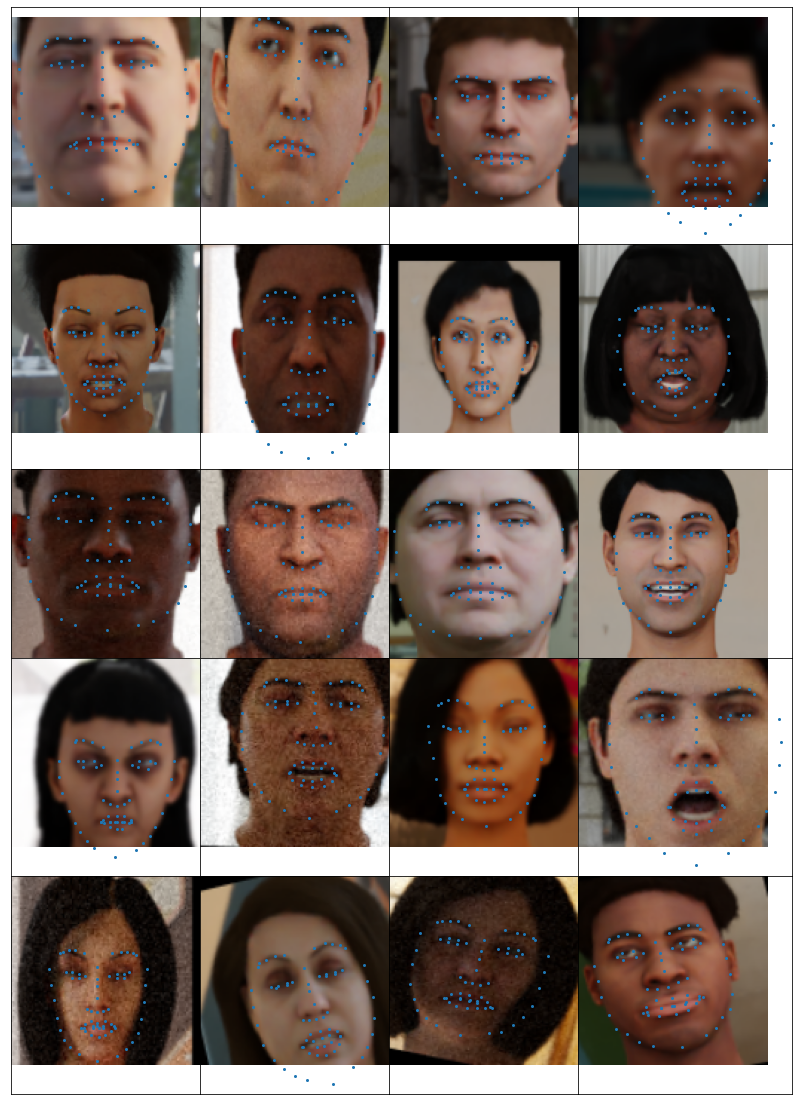

In [107]:
def augment(img, keypoints):
    seq = iaa.Sometimes(0.8, 
        iaa.Sequential([
        iaa.OneOf([iaa.GaussianBlur(sigma=(0, 2.0)), iaa.AdditiveGaussianNoise(scale=(0, 0.08*255))]),
        #iaa.Fliplr(0.5),
        iaa.OneOf([iaa.Affine(scale=(0.75, 1.25)), iaa.Affine(translate_percent=(0, 0.2)), iaa.Affine(rotate=(-20, 20))]),
        iaa.Crop(percent=(0, 0.2))]))
    keypoints = KeypointsOnImage([Keypoint(x=pt[1], y=pt[0]) for pt in keypoints], shape=img.shape)
    img_augmented, keypoints_augmented = seq(images=[img], keypoints=[keypoints])
    return img_augmented[0], np.flip(keypoints_augmented[0].to_xy_array())


fig_shape = np.array((5, 4))
fig_size = 5 * fig_shape
fig = plt.figure(figsize=fig_size)
grid = ImageGrid(fig, 111, nrows_ncols=fig_shape, axes_pad=0.)

for i, ax in enumerate(grid):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    img_augmented, keypoints_augmented = augment(ds[i].visible_spectrum, ds[i].keypoints.face.standard.coords_2d)
    ax.imshow(img_augmented)
    ax.scatter(keypoints_augmented[:, 1], keypoints_augmented[:, 0], s=4)

We define a function to access the image and its associated label from the datapoint, and perform all the pre-processing.<br>
The keypoints array is being flattened and normalized to image size so that the networks predicts values between [0..1]. This makes the training process more stable.

In [108]:
def Xy_accessor(dp, with_augmentations=False):
    img = dp.visible_spectrum
    keypoints = dp.keypoints.face.standard.coords_2d
    if with_augmentations:
        img, keypoints = augment(img, keypoints)
    img = ToTensor()(img)
    keypoints = torch.tensor((keypoints.flatten()/IMG_SIZE).astype('float32'))
    return img, keypoints

We split the dataset into train and test sets and create two PyTorch data loaders

In [109]:
train_set_size = int(TRAIN_TEST_RATIO * len(ds))
training_data = DGDataset(ds[:train_set_size], Xy_accessor, with_augmentations=True)
test_data = DGDataset(ds[train_set_size:], Xy_accessor, with_augmentations=False)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

## Training setup
We use Adam optimizer with MSE loss and exponential learning rate decay

In [110]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)

# Loss and hyper-parameters configuration
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.97)

summary(model, (3, IMG_SIZE, IMG_SIZE))

Using cpu device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14  

If a weight file already exists, lets load it

In [111]:
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint)

## Training loop

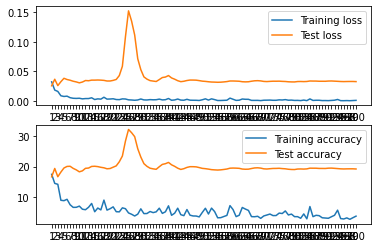

In [112]:
#%matplotlib inline
from IPython import display

plt.figure()
plt.title('Training loss')

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs_list = []
for t in range(EPOCHS):
    display.display(plt.gcf())
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_losses += [train_loss]
    train_accuracies += [train_accuracy]
    test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
    test_losses += [test_loss]
    test_accuracies += [test_accuracy]
    torch.save(model.state_dict(), MODEL_PATH)
    plt.clf()
    plt.xlabel('Epoch')
    epochs_list += [str(t+1)]
    plt.subplot(211)
    plt.plot(epochs_list, train_losses, label='Training loss')
    plt.plot(epochs_list, test_losses, label='Test loss')
    plt.legend()
    plt.subplot(212)
    plt.plot(epochs_list, train_accuracies, label='Training accuracy')
    plt.plot(epochs_list, test_accuracies, label='Test accuracy')
    plt.legend()
    display.clear_output(wait=True)

#print("Training complete!")

## Visualization of the results
Since the network was overfitted, it will provide good results only on training data. Let's have look at some of the networks' predictions on training data

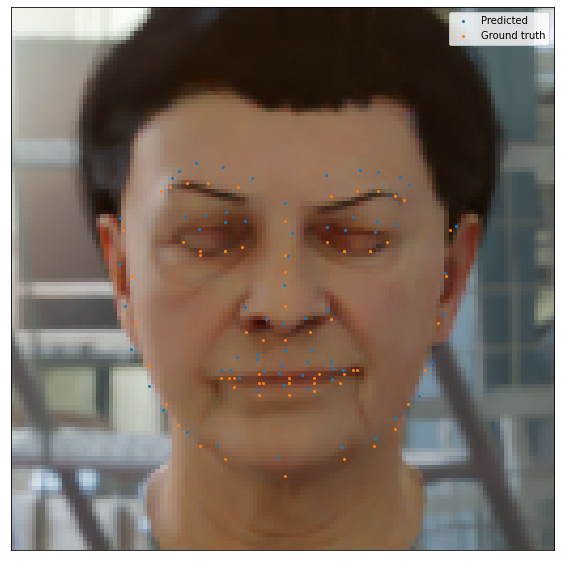

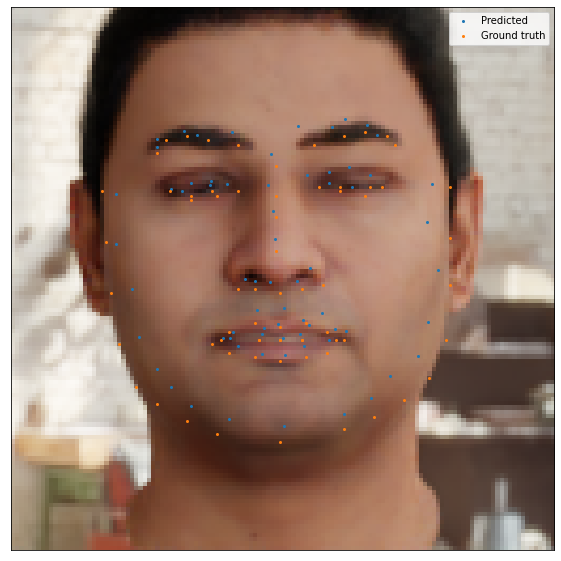

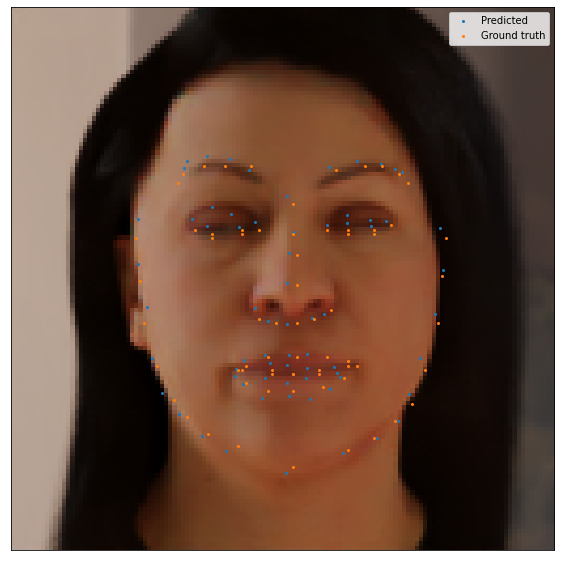

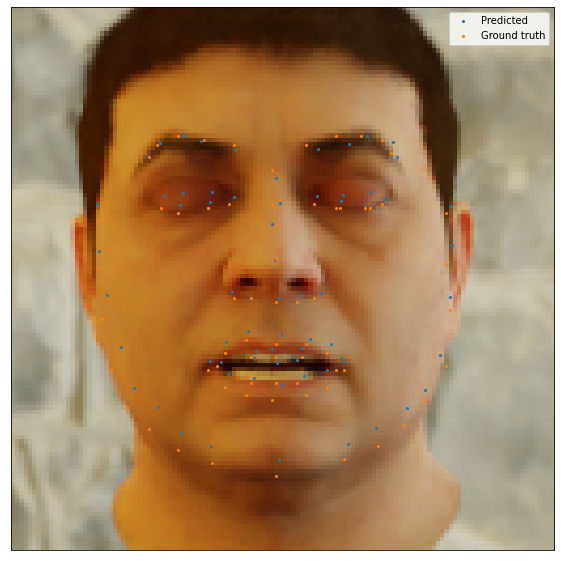

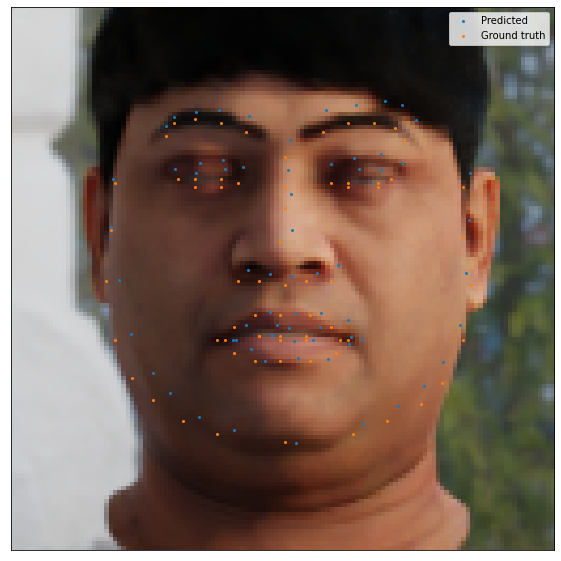

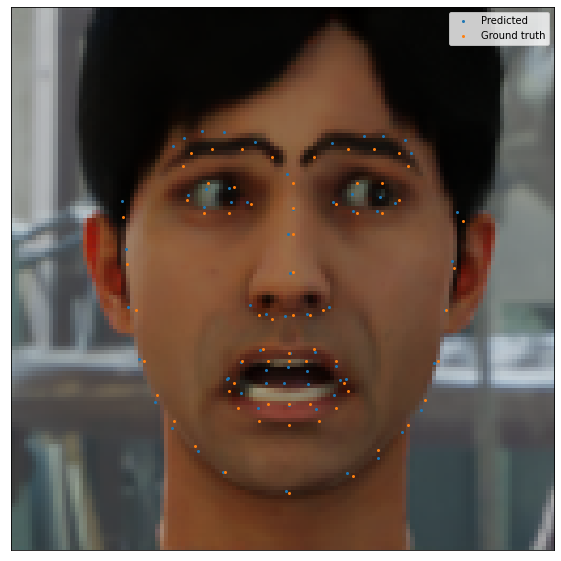

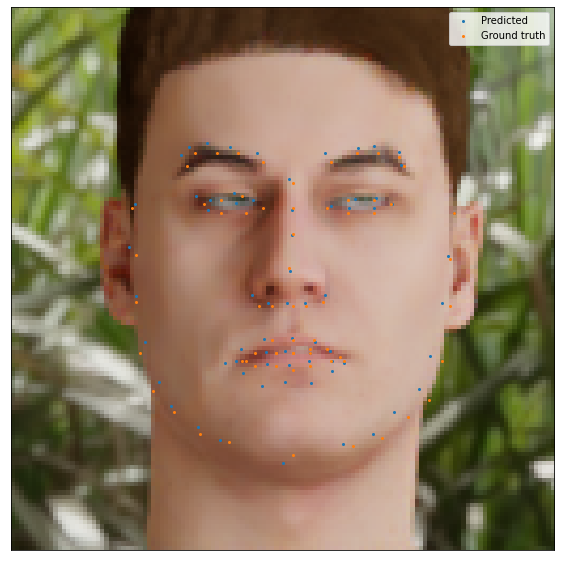

In [116]:
training_data = DGDataset(ds[:train_set_size], Xy_accessor, with_augmentations=False)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

model.eval()
X, y = next(iter(test_dataloader))
X = X.to(device)
y_pred = model(X).detach().numpy()
X = X.detach().numpy()
y = y.detach().numpy()
IMGS_TO_DISPLAY = 6
for i, (img, lms_pred, lms_gt) in enumerate(zip(X, y_pred, y)):
    lms_gt = lms_gt.reshape(NUMBER_OF_KEYPOINTS, 2) * IMG_SIZE
    lms_pred = lms_pred.reshape(NUMBER_OF_KEYPOINTS, 2) * IMG_SIZE
    imshow(np.moveaxis(img, 0, -1))
    plt.scatter(lms_pred[:, 1], lms_pred[:, 0], s=4, label='Predicted')
    plt.scatter(lms_gt[:, 1], lms_gt[:, 0], s=4, label='Ground truth')
    plt.legend()
    plt.show()
    if i >= IMGS_TO_DISPLAY:
        break